### NN Stuff

In [1]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import matplotlib
# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
## Data Plot Prep

# This cell contains the code to prepare the datasets
# It uses sklearn.make_moons that generate sets of data sets to train and test classification algorithms
import sklearn
import sklearn.datasets
import sklearn.linear_model

# Generate a dataset and plot it
#     Npoints is the number of points in the dataset
#     rndm is a random seed so different datasets can be generated
#     noise is a parameter controlling how much points are scattered
def generate_data(Npoints,rndm=0,noise=0.20):
    np.random.seed(rndm)
    X, y = sklearn.datasets.make_moons(Npoints, noise=noise)
    return X,y

# Generate a dataset and plot it
# X,y=generate_data(500)


# Helper function to plot a decision boundary.
# Input: pred_func. A function defined that operates on an array of points. 
#                   pred_func is expected to return an array of 0 and 1 
#                   for each point passed in the input array a 0 or 1 is returned based on the condition
#                   in the function
#
# # If you don't fully understand this function don't worry, it just generates the contour plot below.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)


# Helper function to calculate how often we get the prediction right
# This is the accuracy of our classification e.g. N_right/N_tot
def accuracy(pred_func):
    yhat=pred_func(X)
    return 1.-np.count_nonzero(yhat-y)/len(y) 



# Because the one above doesn't allow the use of separate generated data (Data not called X, y) for Ex.5, and I'm not rewriting the whole code
def plot_decision_boundary1(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)


def accuracy1(pred_func, X, y):
    yhat=pred_func(X)
    return 1.-np.count_nonzero(yhat-y)/len(y) 

In [3]:
# # A simple way to separate the two categories
# def predConst(x,C):
#     return np.where(x[:,1]>C, 0, 1)

# # Use lambda to turn the function into a function of just x
# plot_decision_boundary(lambda x: predConst(x,0.5))
# print("Accuracy",accuracy(lambda x: predConst(x,0.5)) )

### Training Stuff

In [4]:
# These are parameter that are used in the training
# 
#
# num_examples = len(X) # training set size         all in buildmodel
# nn_input_dim = 2 # input layer dimensionality
# nn_output_dim = 2 # output layer dimensionality

# # Gradient descent parameters (I picked these by hand)
# epsilon = 0.01 # learning rate for gradient descent
# reg_lambda = 0.01 # regularization strength     also in calculateloss

In [20]:
# Calculate the value of the output layers a2
def calcProbsNN(model,x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
#     print('x: ',x)
#     print('length: ', len(x))
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    # This is the softmax function
    exp_scores = np.exp(z2)
    # This is a2=yhat, eg the values of the output layer
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)    
    return probs
    
# Helper function to predict an output (0 or 1)
def predict(model, x):
    probs = calcProbsNN(model,x)   
    return np.argmax(probs, axis=1)

In [6]:
# Helper function to evaluate the total loss on the dataset
# See notes from this morning lecture
#
def calculate_loss(model, reg_lambda = 0.01):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    probs = calcProbsNN(model,X)   
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

In [7]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model(nn_hdim, num_passes=20000, print_loss=False, nn_input_dim = 2, nn_output_dim = 2, epsilon = 0.01, reg_lambda = 0.01):
    # Some shit to try fixing things, this hopefully makes it take more than 2 inputs. It also removes the need for nn_input_dim & nn_output_dim
    nn_input_dim = X.shape[1]
    nn_output_dim = X.shape[1]
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))
#     W1 = np.ones(nn_input_dim, nn_hdim)
#     W2 = np.ones(nn_hdim, nn_output_dim)

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}


    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2

        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, calculate_loss(model)))

    return model

### Model Building

In [8]:
# # Build a model with a 3-dimensional hidden layer
# model = build_model(3, print_loss=True,num_passes=500)

# # Plot the decision boundary
# plot_decision_boundary(lambda x: predict(model, x))
# plt.title("Decision Boundary for hidden layer size 3")
# print("Accuracy",accuracy(lambda x: predict(model,x)) )

In [9]:
def DecBound (nlayer, passcnt):
    """Plots the prediction model for a NN of 'nlayer' hidden layers with 'passcnt' passes, and returns the accuracy"""
    model = build_model(nlayer, print_loss=False,num_passes=passcnt)
#     print(model)
    plot_decision_boundary(lambda x: predict(model, x))
    plt.title("Decision Boundary for hidden layer size {}".format(nlayer) )
    print("Accuracy",accuracy(lambda x: predict(model,x)) )
    plt.show()
    return(accuracy1(lambda x: predict(model,x), X, y), model)

#T This is the separate testing function, to save me rewriting everything so far
def DecBound1 (nlayer, passcnt, model, X, y):
    """Plots the prediction model for a NN of 'nlayer' hidden layers with 'passcnt' passes, and returns the accuracy. Similar to DecBound, but requires a premade model. ie for testing the model"""
    plot_decision_boundary1(lambda x: predict(model, x), X, y)
    plt.title("Decision Boundary for hidden layer size {}".format(nlayer) )
    print("Accuracy",accuracy1(lambda x: predict(model,x), X, y))
    plt.show()
    return(accuracy1(lambda x: predict(model,x), X, y), model)

# nlist = [1, 2, 3, 4, 5, 10, 50]
# acclist = []
# modellist = []
# for i in nlist:
#     A, B = DecBound(i, 500) # These don't need sensible names, as they are just to transfer directly to the list
#     acclist.append(A)
#     modellist.append(B)

## Lab 10: Optimise a selection using "neural network" techniques
We optimise the rejection\* efficiency metric by implementing a neural network on the variables that we identified as the most powerful one in the Lab 9.

As we learned in the Lab session 5, it is important to apply our selection to the "test" data set in order to check that we are not training our selections on a statistical fluctuation. For **each** question  of today's lab you should compare the value you achieve for the rejection\* efficiency on the test data set **without** preparing a new selection.

   * Start using only the 2 best variables identified last week and implement a neural network to classify signal and background events. This is very similar to what we did for the 2-dimensional classification exercise with the two variables used being variables from the neutrino data - **Done**
   * Generalise your neural network to take a generic number of variables as input and optmise your selection
   * For each of the optimised selections above, use the test data set to evaluate the rejection\* efficiency
   * How does the neural network method compare to the decision tree implemented last week?


In [10]:
#Imports
import pandas as pd
from pandas import DataFrame
from matplotlib import pyplot as plt

signaldat = pd.read_csv('../data/signal_data.dat', sep = " ")
backgrounddat = pd.read_csv('../data/background_data.dat', sep = " ")

signaltr = pd.read_csv('../data/signal_training.dat', sep = " ")
backgroundtr = pd.read_csv('../data/background_training.dat', sep = " ")


sigframedat = DataFrame(signaldat)
bacframedat = DataFrame(backgrounddat)
sigframetr = DataFrame(signaltr)
bacframetr = DataFrame(backgroundtr)

fulldatanames = list(signaldat.keys())
dataname = list(signaldat.keys())[3:]

In [11]:
# print(dataname)

In [12]:
#Part 1

# effpullx-& effpully are the 2 best vars
# We need to prepare the data sets, so they are in the form required by this NN
# Training Data

# Concatenating the training data into one big dataframe
traindata = pd.concat([sigframetr, bacframetr], axis = 0)
trainclassify = []

# This will give us classifications of the rright length for all our training data (1 for signal, 0 for background)
for i in range(len(sigframetr['effpullx'])):
    trainclassify.append(1)
for i in range(len(bacframetr['effpullx'])):
    trainclassify.append(0)

# Test Data
# All the same stuff, but for test data instead of training. Could be worth making it into a big function.
testdata = pd.concat([sigframedat, bacframedat], axis = 0)
testclassify = []

for i in range(len(sigframedat['effpullx'])):
    testclassify.append(1)
for i in range(len(bacframedat['effpullx'])):
    testclassify.append(0)


Loss after iteration 0: 56.792070


Accuracy 0.76125


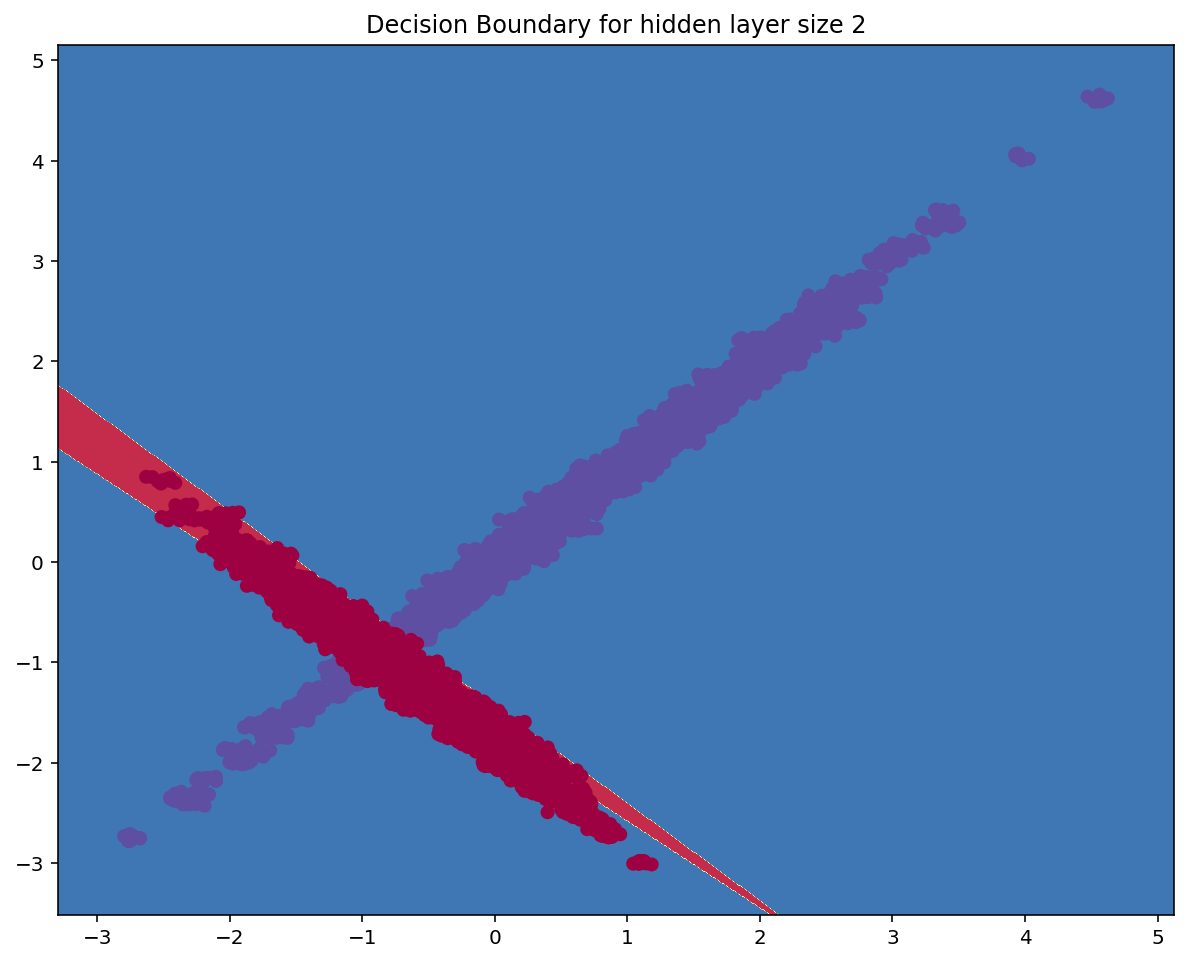

(0.76125, {'W1': array([[-356.55298473, -344.04458665],
         [-367.35317922, -397.88216458]]),
  'b1': array([[-523.68443343, -684.85993413]]),
  'W2': array([[ 96.24503649, -95.86322097],
         [-31.9012688 ,  32.24382163]]),
  'b2': array([[-66.31264394,  66.31264394]])})

In [25]:
X, y = traindata[['effpullx', 'effpully']].values, trainclassify
# Put this directly after wherever we set X
num_examples = len(X)

model = build_model(3, print_loss=True,num_passes=500)

DecBound(2, 5000)

In [0]:
# Part 2

# # Trying to generalise the number of variables
# # Currently, 'x' changes dimensions after the 1st iteration. Need to work out why.

# X, y = traindata[['effpullx', 'effpully', 'efftime']].values, trainclassify
# # Put this directly after wherever we set X
# num_examples = len(X)

# model = build_model(3, print_loss=True,num_passes=500)

# DecBound(2, 5000)

In [15]:
# This doesn't appear to work, but I'm not sure why.
X, y = testdata[['effpullx', 'effpully']].values, testclassify
num_examples = len(X)
# DecBound1(3, 500, model, X, y)
# DecBound(3,5000)

In [23]:
# Part 3

def expval(nA, nAkeep, nBkeep):
    """returns value of Eps X Rho (Efficiency * Purity)"""
    eff = nAkeep/nA
    try:                                     # Yes, we're doing this again, again
        pur = nAkeep / (nAkeep + nBkeep)
    except ZeroDivisionError:
        pur = 0
    return(eff*pur)

# We can say that the accuracy = (n - nBkept)/n = nAkept/n
# So nAkept = acc * n, nBkept = n - (acc * n)
#
acc = accuracy1(lambda x: predict(model,x), X, y)
n = num_examples # Just to save time typing
nAkept = acc * n
nBkept = n - (acc * n)
nA = len(sigframedat['effpullx'])

print('eXr metric for test data: ',expval(nA, nAkept, nBkept))

eXr metric for test data:  0.5102040816326531


In [24]:
# Part 4

# I don't know, as I didn't get the decision tree last session, and the solution we were given doesn't work.
# So I suppose it's better in that it actually gives a result